In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
import pandas as pd

## Prepare Dataset

In [ ]:
data = pd.read_excel("data/synthetic_dataset.xlsx", index_col=0)
data_tensor = torch.tensor(data.values, dtype=torch.float32)


train_tensor, val_tensor = train_test_split(data_tensor, test_size=0.2, random_state=42)

train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

## AutoEncoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, dropout_rate = 0.15):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
                nn.Linear(input_dim, 1028),
                nn.BatchNorm1d(1028),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(1028, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(512, embedding_dim),
            )

        self.decoder = nn.Sequential(
                nn.Linear(embedding_dim, 1028),
                nn.BatchNorm1d(1028),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(1028, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Linear(512, input_dim),
                nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = data.shape[1]
embedding_dim = 32
model = Autoencoder(input_dim, embedding_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [ ]:
def train(num_epochs, model, train_dataloader, val_dataloader):

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        
        # Training phase
        for batch in train_dataloader:
            optimizer.zero_grad()
            inputs = batch[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                inputs = batch[0].to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, inputs)
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_val_loss = total_val_loss / len(val_dataloader)
        
        print(f'Epoch: {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')

In [ ]:
train(20,model, train_dataloader, val_dataloader)

In [ ]:
torch.save(model,"auto_encoder.pkl")

## Evaluate

In [ ]:
model.eval()

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_13682/1776895285.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], cmap='viridis', alpha=0.5)


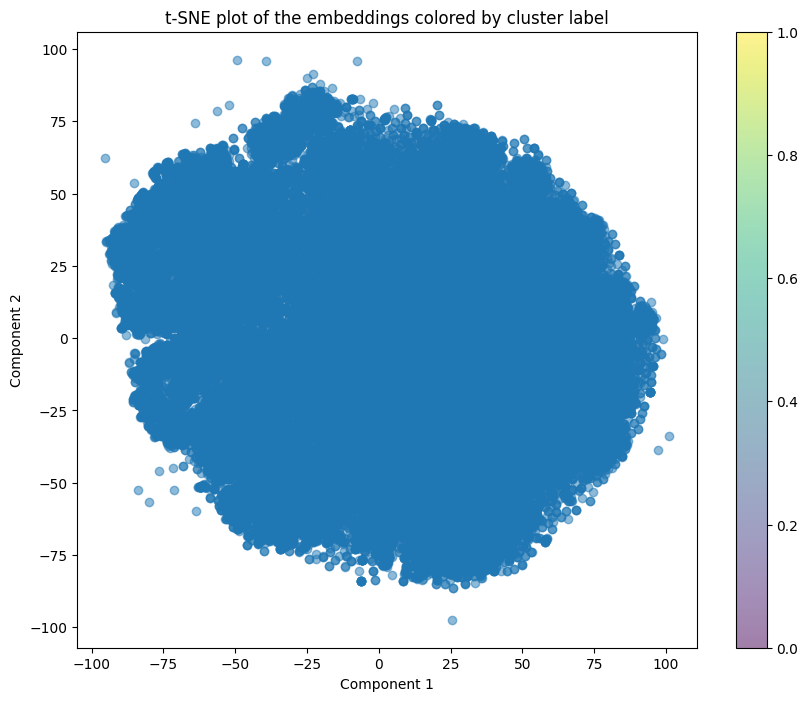

In [29]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embeddings = model(data_tensor.float()).detach()
embeddings_2d = TSNE(n_components=2, random_state=0).fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], cmap='viridis', alpha=0.5)
plt.colorbar()  # To show the color scale
plt.title('t-SNE plot of the embeddings colored by cluster label')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [ ]:
data = pd.read_excel("data/synthetic_dataset.xlsx", index_col=0)
embeddings_2d = TSNE(n_components=2, random_state=0).fit_transform(data)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], cmap='viridis', alpha=0.5)
plt.colorbar()  # To show the color scale
plt.title('t-SNE plot of the actual data')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()